In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf    
import numpy as np  
import keras_tuner as kt
  
# 加载并预处理CIFAR10数据集  
(x, y), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() 
x = x.reshape(x.shape[0], -1)
x = x.astype('float32') / 255.0
x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255.0
y = tf.keras.utils.to_categorical(y)
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, y_train.shape

((40000, 3072), (40000, 10))

In [2]:
def build_and_train(use_bn=False, use_selu=False, dropout_rate=0):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(20):
        if use_selu:
            model.add(tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))
            if dropout_rate > 0:
                model.add(tf.keras.layers.AlphaDropout(dropout_rate))
        else:
            model.add(tf.keras.layers.Dense(100, activation='swish', kernel_initializer='he_normal'))
            if use_bn:
                model.add(tf.keras.layers.BatchNormalization())
            if dropout_rate > 0:
                model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(10, activation='softmax'))  # output
    return model

class find_better_learning_rate(kt.HyperModel):
    def __init__(self, model, tunable=True, min_lr=1e-7, max_lr=1e-1, batch_size=32, epochs=5):
        super().__init__(self, tunable=tunable)
        self.epochs = epochs
        self.lr_model = model
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.batch_size = batch_size
        
    def build(self, hp):
        return self.lr_model
    
    def fit(self, hp, model, x, y, **kwargs):
        learning_rate = hp.Float('learning_rate', min_value=self.min_lr, max_value=self.max_lr, sampling='log')
        model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
        return model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs, **kwargs)

lr_model = find_better_learning_rate(model=build_and_train(), min_lr=1e-7, max_lr=1, batch_size=64)
better_model = kt.BayesianOptimization(lr_model, objective='val_loss', max_trials=15, overwrite=True, directory='./better_lr', project_name='better_lr')

better_model.search(x_train, y_train, validation_data=(x_val, y_val))
better_model.get_best_hyperparameters()[0].values

Trial 15 Complete [00h 00m 46s]
val_loss: 2.388784408569336

Best val_loss So Far: 2.1610350608825684
Total elapsed time: 00h 11m 04s


{'learning_rate': 1.932546009631268e-06}

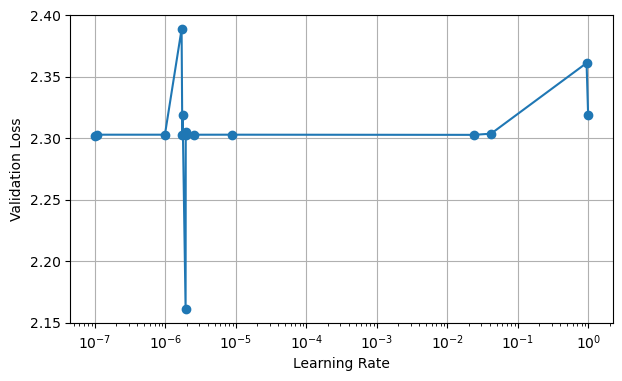

In [3]:
from matplotlib import pyplot as plt

trials = better_model.oracle.trials
lrs = []
losses = []

for trial_id, trial in trials.items():
    lr = trial.hyperparameters.get('learning_rate')
    val_loss_history = trial.metrics.get_history('val_loss')
    if val_loss_history:  # 检查是否有记录
        val_loss_values = [obs.value for obs in val_loss_history]
        best_val_loss = min(val_loss_values)  # 取最小值
        lrs.append(lr)
        losses.append(best_val_loss)
 
# 转换为 NumPy 数组并排序（按学习率升序）
lrs = np.array(lrs)
losses = np.array(losses)
sorted_idx = np.argsort(lrs)
lrs_sorted = lrs[sorted_idx]
losses_sorted = losses[sorted_idx]
 
# 绘制学习率 vs. 验证损失曲线
plt.figure(figsize=(7, 4))
plt.plot(lrs_sorted, losses_sorted, 'o-')
plt.xscale('log')  # 学习率通常用对数坐标
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

In [4]:
optimal_lr = better_model.get_best_hyperparameters()[0].values["learning_rate"]
 
# 基础模型训练
base_model = build_and_train()
base_model.compile(optimizer=tf.keras.optimizers.Nadam(optimal_lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
 
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
history_base = base_model.fit(x_train, y_train,
                            validation_split=0.2,
                            batch_size=128,
                            epochs=100,
                            callbacks=[early_stopping],
                            verbose=1)


Epoch 1/100
250/250 [==============================] - 7s 16ms/step - loss: 2.3017 - accuracy: 0.1072 - val_loss: 2.2975 - val_accuracy: 0.0997
Epoch 2/100
250/250 [==============================] - 3s 13ms/step - loss: 2.2921 - accuracy: 0.1034 - val_loss: 2.2830 - val_accuracy: 0.1081
Epoch 3/100
250/250 [==============================] - 3s 13ms/step - loss: 2.2816 - accuracy: 0.1069 - val_loss: 2.2708 - val_accuracy: 0.1103
Epoch 4/100
250/250 [==============================] - 3s 13ms/step - loss: 2.2707 - accuracy: 0.1103 - val_loss: 2.2578 - val_accuracy: 0.1149
Epoch 5/100
250/250 [==============================] - 3s 13ms/step - loss: 2.2584 - accuracy: 0.1166 - val_loss: 2.2440 - val_accuracy: 0.1196
Epoch 6/100
250/250 [==============================] - 3s 13ms/step - loss: 2.2445 - accuracy: 0.1281 - val_loss: 2.2292 - val_accuracy: 0.1335
Epoch 7/100
250/250 [==============================] - 3s 13ms/step - loss: 2.2306 - accuracy: 0.1415 - val_loss: 2.2161 - val_accuracy:

Epoch 1/100
500/500 [==============================] - 15s 19ms/step - loss: 2.9928 - accuracy: 0.1048 - val_loss: 2.9033 - val_accuracy: 0.1007
Epoch 2/100
500/500 [==============================] - 8s 17ms/step - loss: 2.9728 - accuracy: 0.1072 - val_loss: 3.3038 - val_accuracy: 0.1037
Epoch 3/100
500/500 [==============================] - 9s 17ms/step - loss: 2.9481 - accuracy: 0.1035 - val_loss: 3.2453 - val_accuracy: 0.1025
Epoch 4/100
500/500 [==============================] - 8s 16ms/step - loss: 2.9245 - accuracy: 0.1016 - val_loss: 3.2248 - val_accuracy: 0.1051
Epoch 5/100
500/500 [==============================] - 8s 17ms/step - loss: 2.9158 - accuracy: 0.1047 - val_loss: 3.1856 - val_accuracy: 0.1072
Epoch 6/100
500/500 [==============================] - 8s 17ms/step - loss: 2.8869 - accuracy: 0.1032 - val_loss: 3.1433 - val_accuracy: 0.1063
Epoch 7/100
500/500 [==============================] - 8s 17ms/step - loss: 2.8627 - accuracy: 0.1064 - val_loss: 3.0930 - val_accuracy

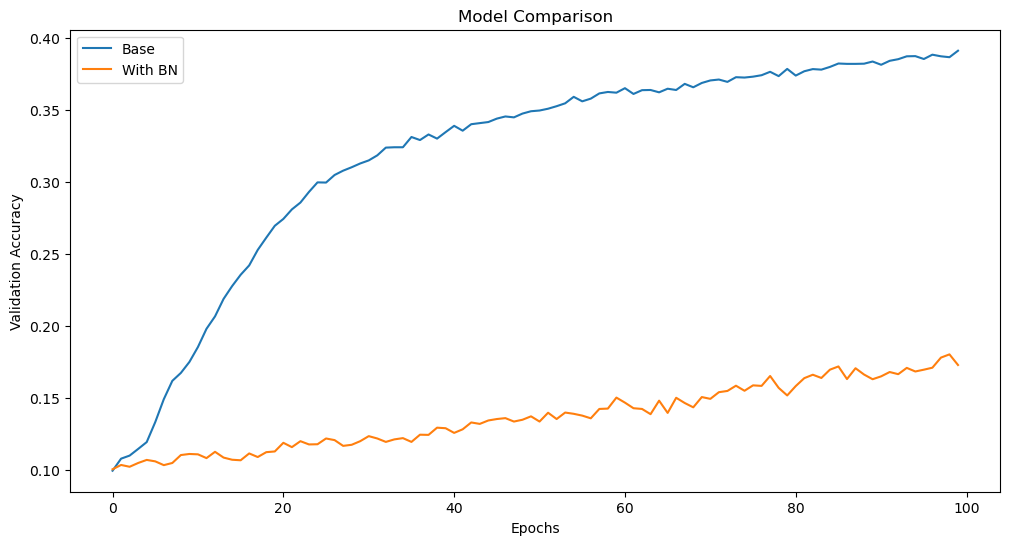

In [10]:
# 带BN的模型
bn_model = build_and_train(use_bn=True)
bn_model.compile(optimizer=tf.keras.optimizers.Nadam(optimal_lr),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
 
history_bn = bn_model.fit(x_train, y_train,
                         validation_split=0.2,
                         batch_size=64,
                         epochs=100,
                         callbacks=[early_stopping],
                         verbose=1)
 
# 比较学习曲线
def plot_histories(*histories, labels):
    plt.figure(figsize=(12, 6))
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=label)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.title('Model Comparison')
    plt.show()
 
plot_histories(history_base, history_bn, labels=['Base', 'With BN'])


Epoch 1/100
250/250 [==============================] - 6s 13ms/step - loss: 2.6344 - accuracy: 0.1331 - val_loss: 2.4068 - val_accuracy: 0.1673
Epoch 2/100
250/250 [==============================] - 3s 11ms/step - loss: 2.3043 - accuracy: 0.1864 - val_loss: 2.2273 - val_accuracy: 0.2095
Epoch 3/100
250/250 [==============================] - 3s 11ms/step - loss: 2.1700 - accuracy: 0.2223 - val_loss: 2.1318 - val_accuracy: 0.2359
Epoch 4/100
250/250 [==============================] - 3s 10ms/step - loss: 2.0925 - accuracy: 0.2444 - val_loss: 2.0704 - val_accuracy: 0.2531
Epoch 5/100
250/250 [==============================] - 3s 10ms/step - loss: 2.0396 - accuracy: 0.2662 - val_loss: 2.0298 - val_accuracy: 0.2688
Epoch 6/100
250/250 [==============================] - 3s 10ms/step - loss: 1.9996 - accuracy: 0.2809 - val_loss: 1.9988 - val_accuracy: 0.2830
Epoch 7/100
250/250 [==============================] - 3s 10ms/step - loss: 1.9671 - accuracy: 0.2921 - val_loss: 1.9740 - val_accuracy:

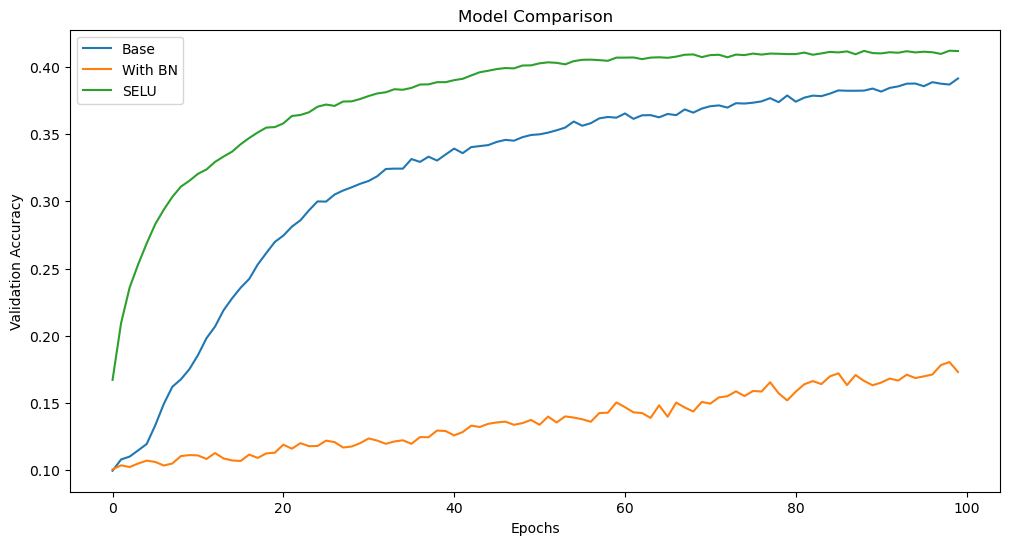

In [11]:
# SELU模型（需要归一化输入）
x_train_selu = (x_train - 0.5) * 2  # 近似归一化到N(0,1)
x_test_selu = (x_test - 0.5) * 2
 
selu_model = build_and_train(use_selu=True)
selu_model.compile(optimizer=tf.keras.optimizers.Nadam(optimal_lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
 
history_selu = selu_model.fit(x_train_selu, y_train,
                            validation_split=0.2,
                            batch_size=128,
                            epochs=100,
                            callbacks=[early_stopping],
                            verbose=1)
 
plot_histories(history_base, history_bn, history_selu,
               labels=['Base', 'With BN', 'SELU'])

In [12]:
# 带Alpha Dropout的模型
dropout_model = build_and_train(use_selu=True, dropout_rate=0.1)
dropout_model.compile(optimizer=tf.keras.optimizers.Nadam(optimal_lr),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
 
history_dropout = dropout_model.fit(x_train_selu, y_train,
                                  validation_split=0.2,
                                  batch_size=128,
                                  epochs=100,
                                  callbacks=[early_stopping],
                                  verbose=1)
 
# MC Dropout评估
class MCDropoutModel(tf.keras.Model):
    def __init__(self, base_model, num_samples=10):
        super().__init__()
        self.base_model = base_model  # 基础模型（如预训练的CNN）
        self.num_samples = num_samples  # MC采样次数
        
        # 冻结基础模型的权重（可选）
        self.base_model.trainable = False
 
    def call(self, inputs):
        # 多次采样预测（启用Dropout）
        preds = []
        for _ in range(self.num_samples):
            pred = self.base_model(inputs, training=True)
            preds.append(pred)
        return tf.reduce_mean(preds, axis=0)
 
mc_model = MCDropoutModel(dropout_model)
mc_preds = mc_model(x_test_selu)
mc_accuracy = tf.keras.metrics.categorical_accuracy(y_test, mc_preds)
print(f"MC Dropout Accuracy: {tf.reduce_mean(mc_accuracy).numpy():.4f}")

Epoch 1/100
250/250 [==============================] - 7s 17ms/step - loss: 3.0696 - accuracy: 0.1002 - val_loss: 2.7188 - val_accuracy: 0.1375
Epoch 2/100
250/250 [==============================] - 4s 17ms/step - loss: 3.0697 - accuracy: 0.0985 - val_loss: 2.5795 - val_accuracy: 0.1590
Epoch 3/100
250/250 [==============================] - 4s 16ms/step - loss: 3.0259 - accuracy: 0.1018 - val_loss: 2.5160 - val_accuracy: 0.1754
Epoch 4/100
250/250 [==============================] - 4s 16ms/step - loss: 3.0184 - accuracy: 0.1004 - val_loss: 2.4814 - val_accuracy: 0.1839
Epoch 5/100
250/250 [==============================] - 4s 16ms/step - loss: 2.9871 - accuracy: 0.1039 - val_loss: 2.4750 - val_accuracy: 0.1893
Epoch 6/100
250/250 [==============================] - 4s 16ms/step - loss: 2.9899 - accuracy: 0.1005 - val_loss: 2.4811 - val_accuracy: 0.1940
Epoch 7/100
250/250 [==============================] - 4s 16ms/step - loss: 2.9643 - accuracy: 0.1012 - val_loss: 2.4911 - val_accuracy:

Epoch 1/50
250/250 [==============================] - 13s 23ms/step - loss: 2.0616 - accuracy: 0.2567 - val_loss: 3.3715 - val_accuracy: 0.2926
Epoch 2/50
250/250 [==============================] - 5s 19ms/step - loss: 1.8423 - accuracy: 0.3373 - val_loss: 2.7243 - val_accuracy: 0.3005
Epoch 3/50
250/250 [==============================] - 5s 19ms/step - loss: 1.7690 - accuracy: 0.3670 - val_loss: 3.5660 - val_accuracy: 0.2946
Epoch 4/50
250/250 [==============================] - 5s 19ms/step - loss: 1.7432 - accuracy: 0.3810 - val_loss: 3.3934 - val_accuracy: 0.3005
Epoch 5/50
250/250 [==============================] - 5s 19ms/step - loss: 1.7103 - accuracy: 0.3948 - val_loss: 4.1379 - val_accuracy: 0.3334
Epoch 6/50
250/250 [==============================] - 5s 19ms/step - loss: 1.6924 - accuracy: 0.4044 - val_loss: 3.5623 - val_accuracy: 0.3370
Epoch 7/50
250/250 [==============================] - 5s 19ms/step - loss: 1.6866 - accuracy: 0.4000 - val_loss: 3.8248 - val_accuracy: 0.303

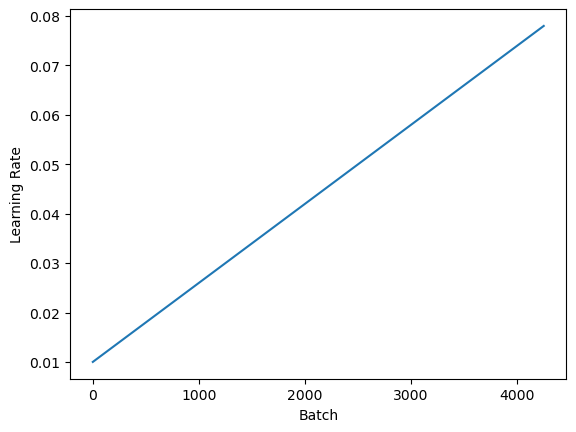

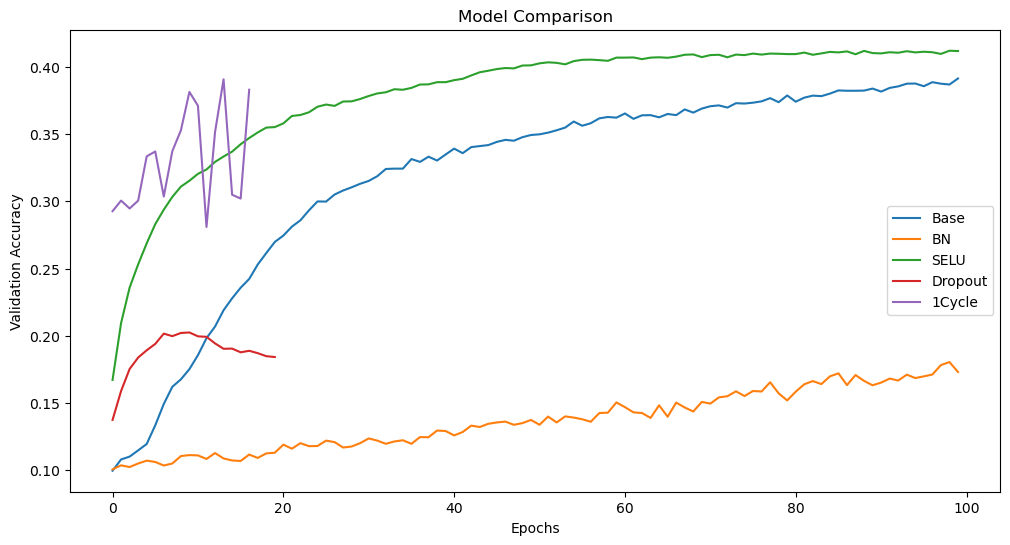

In [23]:
import math


class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0
        self.lrs = []

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.lrs.append(lr)
        self.model.optimizer.learning_rate = lr
 
# 1周期模型
onecycle_model = build_and_train(use_bn=True)
onecycle_model.compile(optimizer=tf.keras.optimizers.Nadam(optimal_lr * 10),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

 
lr_history_cb = OneCycleScheduler(math.ceil(len(x_train) / 64) * 20, max_lr=0.1)
 
history_onecycle = onecycle_model.fit(x_train, y_train,
                                    batch_size=128,
                                    epochs=50,
                                    validation_split=0.2,
                                    callbacks=[early_stopping, lr_history_cb],
                                    verbose=1,
                                   )
 
# 绘制学习率变化
plt.plot(lr_history_cb.lrs)
plt.xlabel('Batch')
plt.ylabel('Learning Rate')
plt.show()
 
# 最终比较
plot_histories(history_base, history_bn, history_selu, 
               history_dropout, history_onecycle,
               labels=['Base', 'BN', 'SELU', 'Dropout', '1Cycle'])